# Check Effective Ringdown Frequency Implementation

* fix implementatin of HM coprecessing eff ringdown freqs by making sure that sign of || final spin is used to select whether pro or retrograde modes are used
* make sure that the non-precessing final spin being used with PhenomXP(with settings to return PhenomX ) gives the correct limits and had the correct smoothness


In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,advanced_gmvx_plot
import lalsimulation as lalsim

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(xcp.core)>> According to the global config, the XCP package is configured to model the [(2, 2), (3, 3)] coprecessing moment multipole moment(s)


In [2]:
?lalsim.SimPhenomPNRwindow

Docstring: SimPhenomPNRwindow(REAL8 m1_SI, REAL8 m2_SI, REAL8 chi1x, REAL8 chi1y, REAL8 chi1z, REAL8 chi2x, REAL8 chi2y, REAL8 chi2z, Dict lalParams) -> REAL8
Type:      builtin_function_or_method


In [3]:
?lalsim.SimPhenomPNRfRingEff

Docstring: SimPhenomPNRfRingEff(REAL8 m1_SI, REAL8 m2_SI, REAL8 chi1x, REAL8 chi1y, REAL8 chi1z, REAL8 chi2x, REAL8 chi2y, REAL8 chi2z, Dict lalParams) -> REAL8
Type:      builtin_function_or_method


In [4]:
?lalsim.SimPhenomPNRafinal

Docstring: SimPhenomPNRafinal(REAL8 m1_SI, REAL8 m2_SI, REAL8 chi1x, REAL8 chi1y, REAL8 chi1z, REAL8 chi2x, REAL8 chi2y, REAL8 chi2z, Dict lalParams) -> REAL8
Type:      builtin_function_or_method


In [5]:
#
def PNRfRingEffaFinal( q, a1, theta_LS, fsflag=None ):
    
    # Import usefuls 
    from numpy import ndarray, array, arange, double
    from positive.units import codef,codeh,codehf,physf
    from positive import sYlm
    import lalsimulation as lalsim
    import lal
    
    #
    m1,m2 = q2m1m2(float(q))
    s1 = array( [a1*sin(theta_LS),0,a1*cos(theta_LS)] )
    
    #
    Mtot = 100.0
    M1 = m1 * Mtot/ ( m1 + m2 )
    M2 = m2 * Mtot / ( m1 + m2 )
    
    #
    lalparams = lal.CreateDict()
    lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lalparams, 0)
    lalsim.SimInspiralWaveformParamsInsertPhenomXReturnCoPrec(lalparams, 1)
    lalsim.SimInspiralWaveformParamsInsertPhenomXPNRUseTunedCoprec(lalparams,1)
    #
    distance_Mpc= 100.0
    distance_SI    = distance_Mpc*1.0e6*lal.PC_SI
    m1_SI = lal.MSUN_SI*M1
    m2_SI = lal.MSUN_SI*M2
    chi1x, chi1y, chi1z = s1
    chi2x, chi2y, chi2z = 0.0,0.0,0.0
    
    #
    # print(chi1x, chi1y, chi1z)
    fRingEff = lalsim.SimPhenomPNRfRingEff( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, lalparams ) 
    aFinal   = lalsim.SimPhenomPNRafinal( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, lalparams ) 
    aFinal_prec   = lalsim.SimPhenomPNRafinal_prec( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, lalparams ) 
    aFinal_nonprec   = lalsim.SimPhenomPNRafinal_nonprec( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, lalparams ) 
    window   = lalsim.SimPhenomPNRwindow( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, lalparams )
    fRINGEffShiftDividedByEmm   = lalsim.SimPhenomPNRfRINGEffShiftDividedByEmm( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, lalparams )
    betaRD   = lalsim.SimPhenomPNRbetaRD( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, lalparams ) 
    betaRD2  = lalsim.SimIMRPhenomX_PNR_GenerateRingdownPNRBeta( m1_SI, m2_SI, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, 0.001, 20.0,250.0,10.0, lalparams ) 
    
    #
    # return { 'fRD':fRingEff, 'af':aFinal, 'window':window, 'fRDshift':fRINGEffShiftDividedByEmm, 'betaRD':betaRD} 
    return (fRingEff, aFinal, aFinal_prec, aFinal_nonprec, window, fRINGEffShiftDividedByEmm, betaRD, betaRD2 )


In [32]:

#
eps = 0.001

#
q = 12
a1 = 0.8
theta_LS = linspace(0+eps,pi-eps,200)


In [33]:
m1,m2 = q2m1m2(q)
_,Xf1 = remnant(m1,m2,a1,0)
_,Xf2 = remnant(m1,m2,-a1,0)

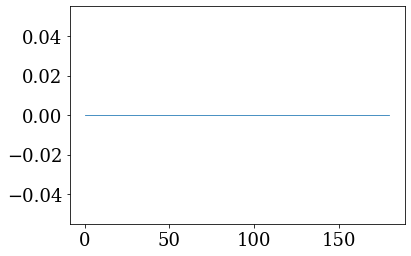

In [34]:


# (fRingEff, aFinal_prec, afinal_nonprec, window, fRINGEffShiftDividedByEmm, betaRD )
data = array( [ PNRfRingEffaFinal( q, a1, th ) for th in theta_LS ] )

#
(fRingEff, aFinal, aFinal_prec, aFinal_nonprec, window, fRINGEffShiftDividedByEmm, betaRD, betaRD2 ) = data.T

# af  = array( [ PNRfRingEffaFinal( q, a1, th )[1] for th in theta_LS ] )
# win  = array( [ PNRfRingEffaFinal( q, a1, th )[3] for th in theta_LS ] )

# plot( theta_LS,aFinal )
# plot( theta_LS,aFinal_test )

plot( theta_LS*180/pi,window )


# #
# figure( figsize=2*figaspect(0.618) )
# plot( theta_LS, fRD, lw=2, label='PNRUseTunedCoprec=True', c='r'  )
# xlabel(r'$\theta_{\mathrm{LS}}$')
# ylabel(r'$f_{\mathrm{RD}}^\mathrm{Effective}$')
# axvline( 120*pi/180, ls='--' )
# axvline( 150*pi/180, ls='--',c='r' )
# # axhline( )
# legend()
# # title('$q10a08$')

# #
# figure( figsize=2*figaspect(0.618) )
# plot( theta_LS, af, lw=2, label='PNRUseTunedCoprec=True', c='b'  )
# xlabel(r'$\theta_{\mathrm{LS}}$')
# ylabel(r'$a_f$')
# axvline( 120*pi/180, ls='--' )
# axhline( Xf1, c='k', ls='--' )
# axhline( Xf2, c='k', ls='--' )
# legend()

Text(0, 0.5, '$\\partial_\\theta \\; f_{\\mathrm{RDEffective}}$')

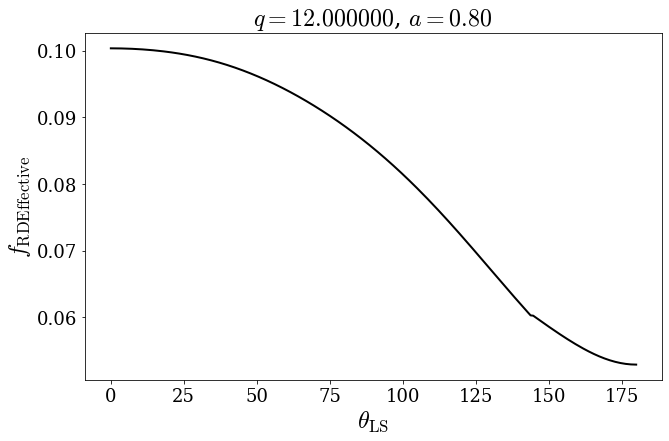

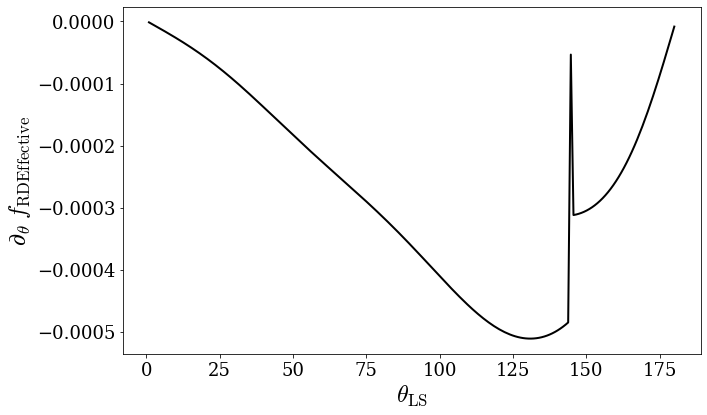

In [35]:

th = theta_LS*180/pi
figure( figsize=1.6*figaspect(0.618) )

plot( th, fRingEff, c='k',lw=2 )
# legend()

title( '$q=%f$, $a=%1.2f$ '%(q,a1) )
xlabel( r'$\theta_{\mathrm{LS}}$' )
ylabel(r'$f_{\mathrm{RDEffective}}$')
# plot( th, sign(cos(betaRD)), label=r'$\mathrm{sign}(\cos(\beta_{\mathrm{RD}})$' )


figure( figsize=1.6*figaspect(0.618) )
plot( th[1:], diff(fRingEff)/diff(th), c='k',lw=2 )
xlabel( r'$\theta_{\mathrm{LS}}$' )
ylabel(r'$\partial_\theta \; f_{\mathrm{RDEffective}}$')

#plot( th, cos(betaRD) )

#
# savefig('/Users/book/Desktop/phenomx_chi_final_a%i_q%f.png'%(a1*10,q))

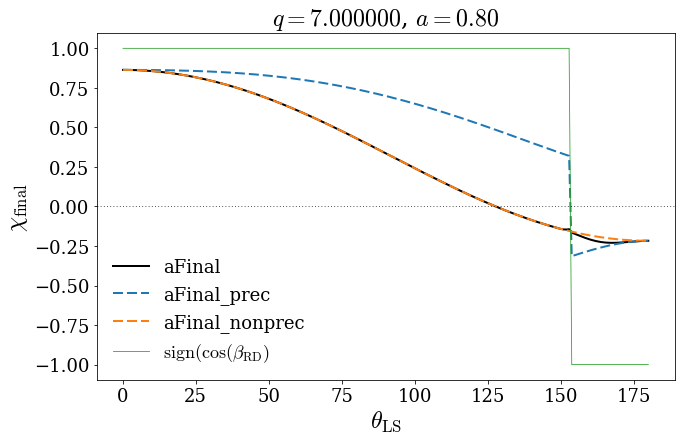

In [22]:

th = theta_LS*180/pi
figure( figsize=1.6*figaspect(0.618) )

plot( th, aFinal, c='k', label='aFinal',lw=2 )
plot( th, aFinal_prec, label='aFinal_prec',ls='--',lw=2 )
plot( th, aFinal_nonprec, label='aFinal_nonprec',ls='--',lw=2 )
plot( th, sign(cos(betaRD)), label=r'$\mathrm{sign}(\cos(\beta_{\mathrm{RD}})$' )
legend()

title( '$q=%f$, $a=%1.2f$ '%(q,a1) )
xlabel( r'$\theta_{\mathrm{LS}}$' )
ylabel(r'$\chi_{\mathrm{final}}$')

axhline(0,c='k',ls=':')

#figure()
#plot( th, cos(betaRD) )

#
# savefig('/Users/book/Desktop/phenomx_chi_final_a%i_q%f.png'%(a1*10,q))

In [11]:
# test_aFinal_prec = aFinal_prec

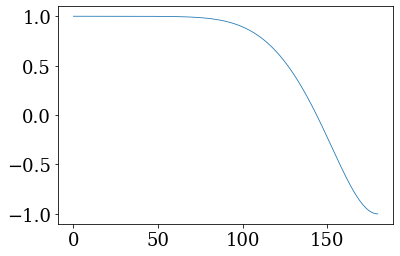

In [12]:
plot(th, cos(betaRD) )

In [13]:
(180-150)*pi/180

0.5235987755982988